# Transfer learning with Tensorflow Part 1: Feature extraction

Transfer learning is leveraging a working model's existing architecture and learn patterns for our own problems.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

# Downloading and becoming one with the data

In [1]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()


Saved under 10_food_classes_10_percent.zip


In [2]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent\test
There are 0 directories and 250 images in 10_food_classes_10_percent\test\chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent\test\chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent\test\fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent\test\grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent\test\hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent\test\ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent\test\pizza
There are 0 directories and 250 images in 10_food_classes_10_percent\test\ramen
There are 0 directories and 250 images in 10_food_classes_10_percent\test\steak
There are 0 directories and 250 images in 10_food_classes_10_percent\test\sushi
There are 10 directori

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [3]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir =  '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print('Train images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                         target_size = IMAGE_SHAPE,
                                                         batch_size = BATCH_SIZE,
                                                         class_mode = 'categorical')

print('Testing images:')
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                       target_size = IMAGE_SHAPE,
                                                       batch_size = BATCH_SIZE,
                                                       class_mode = 'categorical')

Train images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks are:

* Tracking experiments with Tensorboard callback.
* Model Checkpoint with ModelCheckPoint callback.
* Stopping model from training (before it trains too long and overfits) with the EarlyStopping callback.

In [4]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    print(f'Saving TensorBoard log files to: {log_dir}')
    return tensorboard_callback

> 🔑**Note:** you can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option

## Creating models using Tensorflow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch

Now we're going to do similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the Tensorflow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [5]:
# Let's compare the following two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [6]:
# Import dependecies 
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes =10):
    '''
    Takes a tensorflow hub url and creates a Keras Sequential model with it
    
    Args:
        model_url (str) : A tensorflow hub feature extraction URL.
        num_classes (int) : Number of output neurons in the output layer, should
            be equal to number of target classes, default 10. 
    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor layer
        and Dense output layer with num-classes output neurons.
    '''
    # Download the pretrained model and save it as a Keras Layer
    feature_extraction_layer = hub.KerasLayer(model_url, 
                                            trainable = False,
                                            name = 'feature_extraction_layer',
                                            input_shape = IMAGE_SHAPE+(3, )) # freeze already learned patterns
    # Create our own model
    model = tf.keras.Sequential([
        feature_extraction_layer,
        layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
    ])
    
    return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction Model

In [8]:
# Create Resnet model
resnet_model = create_model(resnet_url, 
                           num_classes = train_data_10_percent.num_classes)

In [9]:
# Compile our resnet model
resnet_model.compile(loss = 'categorical_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [10]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resenet_history = resnet_model.fit(train_data_10_percent,
                            epochs = 5, 
                            callbacks = [create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                    experiment_name = 'resnet50V2')],
                            validation_data=test_data_10_percent, 
                            steps_per_epoch = len(train_data_10_percent),
                            validation_batch_size= len(test_data_10_percent))

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20210913-203653
Epoch 1/5
24/24 [==============================] - 30s 1s/step - loss: 1.9346 - accuracy: 0.3587 - val_loss: 1.2215 - val_accuracy: 0.5984
Epoch 2/5
24/24 [==============================] - 20s 847ms/step - loss: 0.8941 - accuracy: 0.7493 - val_loss: 0.8682 - val_accuracy: 0.7188
Epoch 3/5
24/24 [==============================] - 20s 834ms/step - loss: 0.6357 - accuracy: 0.8200 - val_loss: 0.7551 - val_accuracy: 0.7600
Epoch 4/5
24/24 [==============================] - 20s 839ms/step - loss: 0.4779 - accuracy: 0.8667 - val_loss: 0.7162 - val_accuracy: 0.7632
Epoch 5/5
24/24 [==============================] - 19s 822ms/step - loss: 0.3911 - accuracy: 0.9027 - val_loss: 0.6868 - val_accuracy: 0.7700


Wow! 

That is incredible! Our transfer learning feature extractor model out performed ALL of the previous model we built by hand ... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [11]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script helper.py and import it when you need it...
import matplotlib.pyplot as plt

# Plot the valdition and training curves
def plot_loss_curves(history):
    '''
    Returns separte loss curves for training and validation metrics
    
    Args:
        history: Tensorflow history object.
        
    Returns:
        Plots of training/validation loss and accuracy metrics
    '''
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    # plot loss
    plt.plot(epochs, loss, label = 'training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label = 'training_accuracy')
    plt.plot(epochs, val_accuracy, label = 'val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylim([0, 1])
    plt.legend()
    
    plt.show()
    

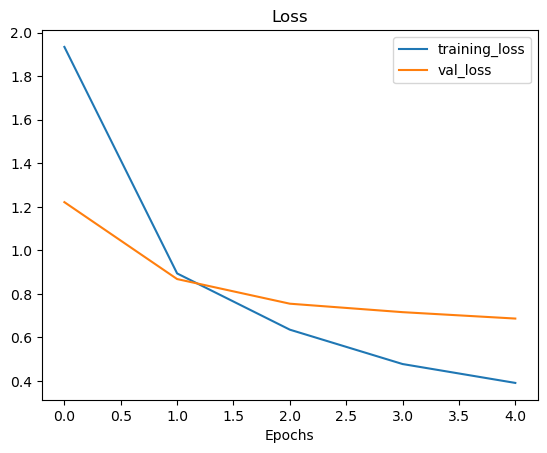

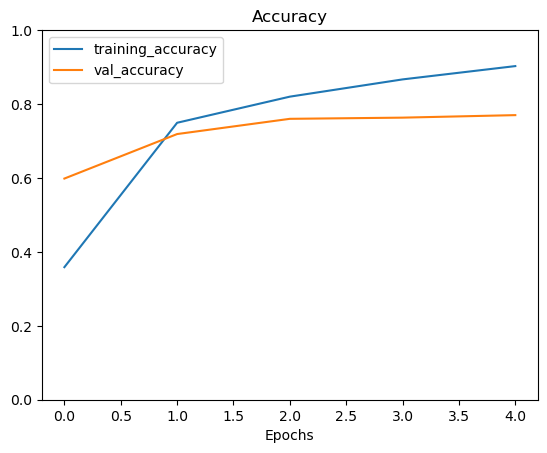

In [12]:
plot_loss_curves(resenet_history)

### Creating and testing EfficientNet TensorFlow Hub Feature Extraction Model

In [13]:
# Create EfficientnetB0 feature extractor model
efficientnet_model = create_model(efficientnet_url, 
                                  num_classes = train_data_10_percent.num_classes)

# Compile EfficientNetModel
efficientnet_model.compile(loss = 'categorical_crossentropy',
                          optimizer = tf.keras.optimizers.Adam(),
                          metrics = ['accuracy'])

# Fit Efficienet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                             epochs=5,
                                             validation_data = test_data_10_percent,
                                             validation_steps= len(test_data_10_percent),
                                             steps_per_epoch = len(train_data_10_percent),
                                             callbacks = [create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                    experiment_name='efficientnetb0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20210913-203853
Epoch 1/5
24/24 [==============================] - 32s 979ms/step - loss: 1.7856 - accuracy: 0.4907 - val_loss: 1.2629 - val_accuracy: 0.7396
Epoch 2/5
24/24 [==============================] - 18s 750ms/step - loss: 1.0333 - accuracy: 0.7827 - val_loss: 0.8555 - val_accuracy: 0.8184
Epoch 3/5
24/24 [==============================] - 20s 860ms/step - loss: 0.7383 - accuracy: 0.8333 - val_loss: 0.6910 - val_accuracy: 0.8472
Epoch 4/5
24/24 [==============================] - 16s 704ms/step - loss: 0.5968 - accuracy: 0.8773 - val_loss: 0.6039 - val_accuracy: 0.8572
Epoch 5/5
24/24 [==============================] - 16s 698ms/step - loss: 0.5091 - accuracy: 0.8933 - val_loss: 0.5547 - val_accuracy: 0.8656


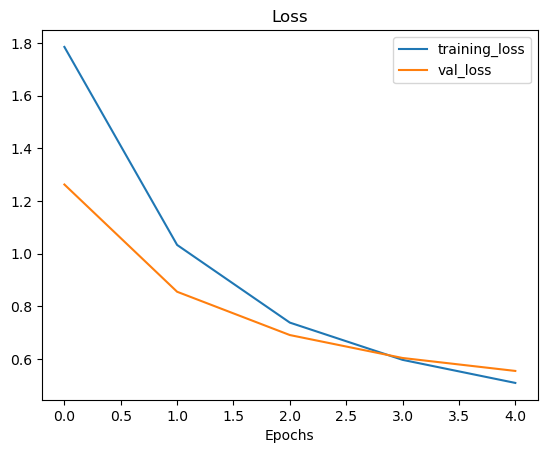

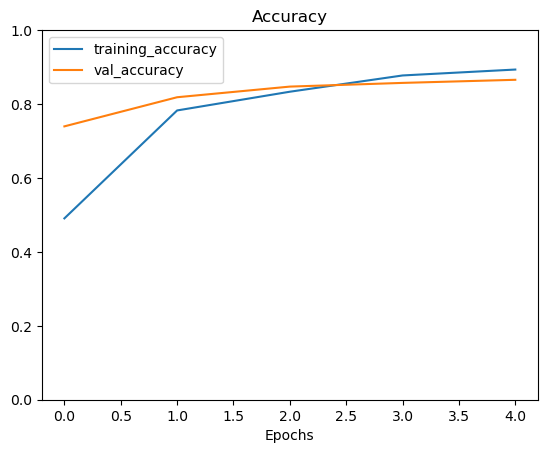

In [14]:
plot_loss_curves(efficientnet_history)

In [15]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [16]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [17]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g. using ImageNet model on 1000 classes, none of your own)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNEtB0 trained on ImageNet) and adjust output layer for your own problem (e.g. 1000 classes  -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> 🔑 **Note:** When you upload things to TensorBoard.dev, you experiments are public. So if you're running private experiments (things you don't want other to see) do not upload them to TensorBoard.dev

In [18]:
# Upload TensorBoard dev records
!tensorboard dev --auth_force_console upload --logdir ./tensorflow_hub/ \
    --name "EfficientNetB0 vs ResNet50V2" \
    --description "Comparing two different TF Hub feature extraction model architecture using 10% of training data" \
    --one_shot 

^C
